<a href="https://colab.research.google.com/github/Page0526/Pytorch-crash-course/blob/main/deep-neural-networks/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ý tưởng của VAE là encode input dưới latent space xong đó decode ra output (reconstructed image) gần giống với input. Ở đấy input sẽ được encoder as a distribution).
Follow: https://medium.com/@outerrencedl/variational-autoencoder-and-a-bit-kl-divergence-with-pytorch-ce04fd55d0d7

## Preliminaries

In [1]:
!pip install -q lightning wandb torchvision torchinfo torchsummary

In [18]:
import torch
from torch import nn
import torch.nn.functional as F


from torchsummary import summary

import torchvision
from torchvision import transforms

from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

import wandb 
import pytorch_lightning as pl
from pytz import timezone
from datetime import datetime
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from PIL import Image
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torchmetrics import MaxMetric, MeanMetric
from typing import Any, Dict, Tuple, List
from torchmetrics.classification.accuracy import Accuracy
from torchattacks import FGSM

In [4]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb_api_key")
wandb.login(key=wandb_api_key)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Gaussian distribution
$f(x)=\frac1 {\sigma \sqrt{2\pi}}e^{-\frac1 2 (\frac{x-\mu}{\mu})^2}$

In [ ]:
# sampling normal distribution
def normal_sample(x, mean, var):
    return (1/(np.sqrt(2* np.pi * var))) * (np.exp(-0.5 * (x-mean)**2 / var))

In [ ]:
mean = [0.0,0.0,0.0,-2.0]
var = [0.2,1.0,5.0,0.5]
x_range = np.arange(-5.0, 5.0, 0.05)
curves = []

# visualize normal distribution
for i in range(len(mean)):
    crv = [normal_sample(x, mean[i], var[i]) for x in x_range]
    curves.append(crv)
    
plt.figure(figsize=(8,4))
for i in range(len(curves)):
    plt.plot(x_range, curves[i], label=f"$\mu$={mean[i]}, $\sigma^2$={var[i]}")
    
plt.grid("on")
plt.legend()
plt.show

## KL Divergence
$KL=(\mathbb{N}(x|\mu_1,\sigma_1)||\mathbb{N}(x|\mu_2,\sigma_2))=log\frac{\sigma_2}{\sigma_1}+\frac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\frac12$

In [ ]:
kl_loss = lambda mean1, mean2, var1, var2:(
        np.log((var2 / var1)**0.5) + (var1 + (mean1-mean2)**2) / (2 * var2) - 0.5)
print("The KL divergence between curve 0 and curve 1:")
print(f"{kl_loss(mean[0], mean[1], var[0], var[1]):.4f}")

## Point-wise KL divergence
$KL(p||q)=\sum^K_{k=1}p_klogp_k-\sum^K_{k=1}p_klogq_k=\sum^K_{k=1}p_klog\frac{p_k}{q_k}$

In [ ]:
def pt_wise_kl(d_true, d_pred):
    d_pred, d_true = np.array(d_pred), np.array(d_true)
    return np.sum(d_true * np.log(d_true / d_pred))

print(f"{pt_wise_kl(curves[0], curves[1]):.4f}")
print(f"{pt_wise_kl(curves[1], curves[0]):.4f}")

## Loading FashionMNIST Dataset

In [57]:
from torch.utils.data import DataLoader
from torchvision import datasets

trainset = datasets.MNIST(root="data",
                                 train=True,
                                 download=True,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
                                 ]),
                                 target_transform=None 
        )

testset = datasets.MNIST(root="data",
                                train=False,
                                download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                ]),
                                target_transform=None # you can transform labels as well
)

Failed to download (trying next):
HTTP Error 403: Forbidden




100%|██████████| 9912422/9912422 [00:00<00:00, 54449971.38it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden




100%|██████████| 28881/28881 [00:00<00:00, 1622997.89it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden




100%|██████████| 1648877/1648877 [00:00<00:00, 13932992.05it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden




100%|██████████| 4542/4542 [00:00<00:00, 1989611.36it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [58]:
# Checking if CUDA is available on current machine
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Deivce: {DEVICE}')

BATCH_SIZE = 64
EPOCHS = 30
lr = 2e-3
HIDDEN_DIM = 2
labels = trainset.classes

Deivce: cuda


In [59]:
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=3)

Batch shape:  torch.Size([64, 1, 28, 28])


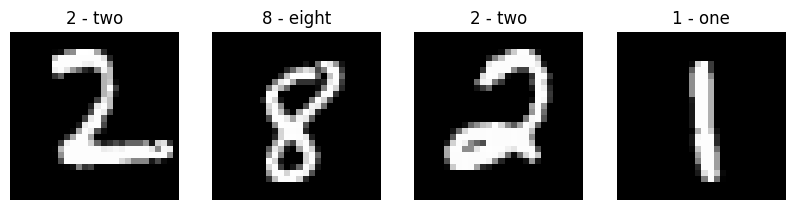

In [60]:
# Visualize data
for _, data in enumerate(train_loader):
  print("Batch shape: ",data[0].shape)
  fig, ax = plt.subplots(1, 4, figsize=(10, 4))

  for i in range(4):
    # Turn 3D tensor to 2D tensor due to image's single channel
    ax[i].imshow(data[0][i].squeeze(), cmap='gray')
    ax[i].axis("off")
    ax[i].set_title(labels[data[1][i]])

  plt.show()
  break

# Classifier

In [66]:
class FashionClassifier(nn.Module):
    def __init__(self, channels:int=1, image_size:int=28):
        super(FashionClassifier, self).__init__()
        self.channels = channels
        self.image_size = image_size

        self.conv1 = nn.Conv2d(self.channels, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1)
       
        self.flatten = nn.Flatten()
    
        self.fc1 = nn.Linear(64 * (image_size // 2) * (image_size // 2), 128)
        self.fc2 = nn.Linear(128, 10)

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        x = self.flatten(x)
        
        x = self.dropout1(x)
        
        x = F.relu(self.fc1(x))
        
        x = self.dropout2(x)
        
        x = self.fc2(x)

        return x

In [8]:
fashion_classifier = FashionClassifier().to(DEVICE)

summary(fashion_classifier, (1, 28, 28))

FashionClassifier(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           1,280
            Conv2d-2           [-1, 64, 14, 14]          73,792
           Flatten-3                [-1, 12544]               0
           Dropout-4                [-1, 12544]               0
            Linear-5                  [-1, 128]       1,605,760
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 10]    

In [87]:
class ClassifierModule(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.net = FashionClassifier()
        self.criterion = nn.CrossEntropyLoss()
        
        self.train_acc = Accuracy(task="multiclass", num_classes=len(labels))
        self.val_acc = Accuracy(task="multiclass", num_classes=len(labels))
        self.test_acc = Accuracy(task="multiclass", num_classes=len(labels))

        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

        self.val_acc_best = MaxMetric()

    def forward(self, x): 
        return self.net(x)

    def model_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor]
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits.float(), y)
        preds = torch.argmax(logits, dim=1)

        return loss, preds, y
        
    def on_train_start(self) -> None:
        """Lightning hook that is called when training begins."""
        # by default lightning executes validation step sanity checks before training starts,
        # so it's worth to make sure validation metrics don't store results from these checks
        self.val_loss.reset()
        self.val_acc.reset()
        self.val_acc_best.reset()

    def training_step(self, batch, batch_idx):
        x, y = batch
        loss, preds, targets = self.model_step(batch)
        
        self.train_loss(loss)
        self.train_acc(preds, targets)
        self.log("train/loss", self.train_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train/acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> None:
        x, y = batch
        loss, preds, targets = self.model_step(batch)

        self.val_loss(loss)
        self.val_acc(preds, targets)
        
        self.log("val/loss", self.val_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/acc", self.val_acc, on_step=False, on_epoch=True, prog_bar=True)

    def on_validation_epoch_end(self) -> None:
        "Lightning hook that is called when a validation epoch ends."
        acc = self.val_acc.compute() 
        self.val_acc_best(acc)  
        self.log("val/acc_best", self.val_acc_best.compute(), sync_dist=True, prog_bar=True)

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> None:
        x, y = batch
        loss, preds, targets = self.model_step(batch)
        
        self.test_loss(loss)
        self.test_acc(preds, targets)
        
        self.log("test/loss", self.test_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test/acc", self.test_acc, on_step=False, on_epoch=True, prog_bar=True)


    def configure_optimizers(self):
        optimizer=torch.optim.Adam(params=self.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=10)
      
        return {
           "optimizer": optimizer,
           "lr_scheduler": {
               "scheduler": scheduler,
               "monitor": "val/loss",
           },
        }    

In [88]:
checkpoint_callback = ModelCheckpoint(
   dirpath="checkpoints",
   monitor="val/loss",
   filename="classifier-{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}",
   save_top_k=3,
   mode="min",
)

early_stopping = EarlyStopping(monitor="val/loss", patience=3, mode="min", verbose=True)

In [89]:
current_datetime = datetime.now(timezone("UTC")).strftime("%Y-%m-%d_%H-%M-%S")
logger = WandbLogger(project="puvae", name=f"run-{current_datetime}", tags= ["fashion", "classifier"])

classifier = ClassifierModule()
trainer = pl.Trainer(
    max_epochs=30,
    logger=logger,
    callbacks = [checkpoint_callback, early_stopping],
    accumulate_grad_batches=2,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices="auto",
)

trainer.fit(classifier, train_dataloaders=train_loader, val_dataloaders=test_loader)

logger.experiment.save("checkpoints/*.ckpt")
wandb.finish()

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Symlinked 12 files into the W&B run directory, call wandb.save again to sync new files.


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train/acc,▁▆▇▇▇█████
train/loss,█▃▂▂▂▁▁▁▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val/acc,▁▃▆▇▇▇████
val/acc_best,▁▃▆▇▇▇████
val/loss,█▅▃▁▂▂▁▂▃▂
epoch,9
train/acc,0.9884
train/loss,0.03565
trainer/global_step,4689


# VAE Architecture

In [90]:
from abc import abstractmethod
from torch import Tensor

class BaseVAE(nn.Module):

    def __init__(self) -> None:
        super().__init__()

    def encode(self, img: Tensor) -> Tuple[Tensor, Tensor]:
        raise NotImplementedError

    def decode(self, z: Tensor) -> Tensor:
        raise NotImplementedError

    @torch.no_grad()
    def sample(self, n_samples: int, device: str = torch.device("cpu")) -> Tensor:
        """_summary_
        Samples from the latent space and return the corresponding image space map.
        Args:
            n_samples (int): Number of samples
            device (str, optional): Device to run the model. Defaults to torch.device("cpu").

        Returns:
            Tensor: _description_
        """

        z = torch.randn(n_samples, self.latent_dims[0], self.latent_dims[1],
                        self.latent_dims[2], device=device)
        return self.decode(z)

    @abstractmethod
    def forward(self, img: Tensor) -> Tuple[Tensor, Dict[str, Tensor]]:
        pass

    @abstractmethod
    def loss_function(self, img: Tensor, recons_img: Tensor,
                      **kwargs) -> Tensor:
        pass

In [91]:
class ConditionalVAE(BaseVAE):
    def __init__(self,
                 in_channels: int,
                 num_classes: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 img_size:int = 64,
                 ) -> None:
        super(ConditionalVAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.img_size = img_size

        self.embed_class = nn.Linear(num_classes, img_size * img_size)
        self.embed_data = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        in_channels += 1 # To account for the extra label channel
        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules) 
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim + num_classes, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1
                                       ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=1,
                                               stride=1,
                                               padding=2),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:

        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)


        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input, y) -> List[Tensor]:
        y = y.float()
        embedded_class = self.embed_class(y)
        embedded_class = embedded_class.view(-1, self.img_size, self.img_size).unsqueeze(1)
        embedded_input = self.embed_data(input)

        x = torch.cat([embedded_input, embedded_class], dim = 1)
        mu, log_var = self.encode(x)

        z = self.reparameterize(mu, log_var)

        z = torch.cat([z, y], dim = 1)

        return  self.decode(z), input, mu, log_var

    def loss_function(self,
                     recons,
                     input,
                     mu, log_var) -> dict:

        kld_weight = 0.0025  # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return loss, recons_loss, kld_loss

    def sample(self,
               num_samples:int,
               current_device: int,
               **kwargs) -> Tensor:
 
        y = kwargs['labels'].float()
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        z = torch.cat([z, y], dim=1)
        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x, **kwargs)[0]

In [116]:
from torchvision.utils import make_grid

class cVAEModule(pl.LightningModule):
    def __init__(self, kl_weight:int=0.0025, rc_weight:int=1, ce_weight: int=10.0):
        super().__init__()
        self.net = ConditionalVAE(in_channels=1,img_size= 28, num_classes=10, latent_dim=32)
        
        self.kl_weight = kl_weight
        self.rc_weight = rc_weight
        self.ce_weight = ce_weight

        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()
        
        self.val_psnr = PeakSignalNoiseRatio()
        self.val_ssim = StructuralSimilarityIndexMeasure()
        self.train_psnr = PeakSignalNoiseRatio()
        self.train_ssim = StructuralSimilarityIndexMeasure()

        self.criterion = nn.CrossEntropyLoss() # for classifier
        self.classifier = FashionClassifier().to(self.device)
        self.load_classifier("/kaggle/input/classifier/pytorch/fashion_classifier/1/fashion_classifier.ckpt")

    def forward(self, batch):
        x, y = batch
        y_one_hot = F.one_hot(y, num_classes=10)
        recons, input, mu, log_var = self.net(x, y_one_hot)
        loss, rc_loss, kl_loss = self.net.loss_function(recons, input, mu, log_var)
        return recons, loss, rc_loss, kl_loss

    def load_classifier(self, ckpt_path):
        checkpoint = torch.load(ckpt_path)
        checkpoint_state_dict = checkpoint['state_dict']
        checkpoint_state_dict = {k.replace('net.', ''): v for k, v in checkpoint_state_dict.items()}
        
        self.classifier.load_state_dict(checkpoint_state_dict)
        self.classifier.eval()
        self.classifier = self.classifier.to(self.device)
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        recons, loss, recons_loss, kl_loss = self.forward(batch)

        preds = self.classifier(recons)
        ce_loss = F.cross_entropy(preds, y)
        
        total_loss = loss + self.ce_weight*ce_loss
        self.train_loss(total_loss)
        self.log("train/loss", self.train_loss, on_step=False, on_epoch=True, prog_bar=True)

        if batch_idx%10 == 0:
            psnr_value = self.train_psnr(recons, x)
            ssim_value = self.train_ssim(recons, x)
            
            reconstruction = make_grid(recons, nrow=10, normalize=True)
            x = make_grid(x, nrow=10, normalize=True)
            preds_labels = preds.argmax(dim=1)
            preds_grid = make_grid(preds_labels.unsqueeze(1).float(), nrow=10, normalize=True)
            
            self.logger.log_image(key='train/image', images=[reconstruction, x_grid, preds_grid], caption=['reconstruction', 'real', 'prediction'])   
            self.log("train/loss", self.train_loss, on_step=False, on_epoch=True, prog_bar=True)
            self.log("train/psnr", psnr_value, on_step=False, on_epoch=True, prog_bar=True)
            self.log("train/ssim", ssim_value, on_step=False, on_epoch=True, prog_bar=True)

        return loss
    

    def on_train_epoch_end(self):
        "Lightning hook that is called when a validation epoch ends."
        self.train_psnr.reset()
        self.train_ssim.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        recons, loss, recons_loss, kl_loss = self.forward(batch)
        
        preds = self.classifier(recons)
        ce_loss = F.cross_entropy(preds, y)

        total_loss = loss + self.ce_weight*ce_loss
        self.val_loss(total_loss)
        self.log("val/loss", self.val_loss, on_step=False, on_epoch=True, prog_bar=True)

        if batch_idx%10 == 0:
            psnr_value = self.val_psnr(recons, x)
            ssim_value = self.val_ssim(recons, x)
            
            reconstruction = make_grid(recons, nrow=10, normalize=True)
            x = make_grid(x, nrow=10, normalize=True)
            
            preds_labels = preds.argmax(dim=1)
            preds_grid = make_grid(preds_labels.unsqueeze(1).float(), nrow=10, normalize=True)
            
            self.logger.log_image(key='val/image', images=[reconstruction, x_grid, preds_grid], caption=['reconstruction', 'real', 'prediction']) 
            self.log("val/psnr", psnr_value, on_step=False, on_epoch=True, prog_bar=True)
            self.log("val/ssim", ssim_value, on_step=False, on_epoch=True, prog_bar=True)

    def on_validation_epoch_end(self):
        "Lightning hook that is called when a validation epoch ends."
        self.val_psnr.reset()
        self.val_ssim.reset()

        
    def test_step(self,  batch, batch_idx):
        x, y = batch
        recons, loss, recons_loss, kl_loss = self.forward(batch)

        self.classifier = self.load_classifier("/kaggle/input/classifier/pytorch/fashion_classifier/1/fashion_classifier.ckpt")
        preds = self.classifier(recons)
        ce_loss = F.cross_entropy(preds, y)
        
        total_loss = loss + self.ce_weight*ce_loss
        self.test_loss(total_loss)
        self.log("test/loss", self.test_loss, on_step=False, on_epoch=True, prog_bar=True)

        if batch_idx%10 == 0:
            
            reconstruction = make_grid(recons, nrow=10, normalize=True)
            x = make_grid(x, nrow=10, normalize=True)
            
            preds_labels = preds.argmax(dim=1)
            preds_grid = make_grid(preds_labels.unsqueeze(1).float(), nrow=10, normalize=True)
            
            self.logger.log_image(key='test/image', images=[reconstruction, x_grid, preds_grid], caption=['reconstruction', 'real', 'prediction']) 

    def configure_optimizers(self):
        optimizer=torch.optim.Adam(params=self.parameters(), lr=1e-4, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=10)
      
        return {
           "optimizer": optimizer,
           "lr_scheduler": {
               "scheduler": scheduler,
               "monitor": "val/loss",
           },
        }


In [109]:
callback = ModelCheckpoint(
   dirpath="checkpoints",
   monitor="train/psnr",
   filename="cVAE-{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}",
   save_top_k=3,
   mode="max",
)

early_stopping = EarlyStopping(monitor="train/ssim", patience=15, mode="max", verbose=True)

In [110]:
# Get the current date and time
current_datetime = datetime.now(timezone("UTC")).strftime("%Y-%m-%d_%H-%M-%S")
logger = WandbLogger(project="puvae", name=f"run-{current_datetime}", tags= ["fashion", "cvae"])

model = cVAEModule()

trainer = pl.Trainer(
    max_epochs=200,
    logger=logger,
    callbacks = [callback, early_stopping],
    accumulate_grad_batches=2,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices="auto",
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

logger.experiment.save("checkpoints/*.ckpt")
wandb.finish()

/tmp/ipykernel_23/496780769.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Symlinked 15 files into the W&B run directory, call wandb.save again to sync new files.


epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
train/loss,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/psnr,▁▃▅▅▅▆▇▇▇███████████████████████████████
train/ssim,▁▂▂▃▃▅▅▅▅▅▅▅▅▅▆▇████████████████████████
trainer/global_step,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇█████
val/loss,█▇▃▄▃▂▃▂▃▂▂▂▂▁▂▂▂▁▂▂▂▁▂▂▂▂▂▂▂▁▁▁▂▂▁▁▂▂▂▂
val/psnr,▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇██▇█▇█▇█▇█▇█▇▇██▇████████
val/ssim,▁▃▄▅▅▆▆▆▆▅▇▇█████▇██████████████████████
epoch,137
train/loss,0.05922
train/psnr,16.18061


# Adding adversarial attacks

In [112]:
%pip install torchattacks

Note: you may need to restart the kernel to use updated packages.


In [117]:
def best_reconstruction(model, logger, x, y, n_classes):
    """Identify best reconstruction from PuVAE."""
    batch_size = x.shape[0]
 
    images = x.repeat_interleave(n_classes, dim=0)
    labels = torch.eye(n_classes, device=x.device).repeat(batch_size, 1)

    reconstructions, vae_loss = model(images, labels)
    errors = F.mse_loss(reconstructions, images, reduction='none').mean(dim=[2, 3])
    errors = errors.view(batch_size, n_classes)

    best_idxs = errors.argmin(dim=1) + torch.arange(0, batch_size, dtype=torch.int64, device=errors.device) * n_classes 
    best_reconstructions = reconstructions[best_idxs]

    return best_reconstructions, errors.min(dim=1).values


def run_attack(model, logger, datamodule, attack):
    """Run adversarial attack and evaluate model performance."""
    correct, total = 0, 0
    n_classes = datamodule.num_classes

    for batch_idx, batch in enumerate(datamodule.test_dataloader()):
        x, y = batch
        x.requires_grad = True
        labels = torch.argmax(y, dim=1)
        
        adv_examples = attack(inputs=x, labels=labels)
        
        with torch.no_grad():
            reconstruction, _ = model(adv_examples, y)
            best_reconstructions, errors = best_reconstruction(model, logger, adv_examples, y, n_classes)
            preds = model.classifier(best_reconstructions)
            preds = torch.argmax(preds, dim=1)
            
            # Calculate accuracy
            correct += (preds == labels).sum().item()
            total += y.size(0)
            
            for i in range(min(len(adv_examples), 5)):  # Log up to 5 examples per batch
                adv_image = adv_examples[i].detach().cpu()
                recon_image = reconstruction[i].detach().cpu()
                original_image = x[i].detach().cpu()
                captions = [f"Label: {labels[i].item()}", f"Prediction: {preds[i].item()}", "Reconstruction"]
                
                logger[0].log_image(key=f"infer/batch_{batch_idx}_adv_example_{i}",
                                 images=[original_image, adv_image, recon_image],
                                 caption=captions)
                

    accuracy = 100 * correct / total
    return accuracy

In [118]:
trainer.test(model=model, dataloaders = test_loader, ckpt_path = '/kaggle/input/puvae/pytorch/default/1/mnist_cvae.ckpt')

attack = FGSM(model.classifier, eps=cfg.test.attack_eps)

accuracy = run_attack(model, logger, datamodule, attack)

logger.log_metrics({"infer/acc": accuracy})

RuntimeError: Error(s) in loading state_dict for cVAEModule:
	Missing key(s) in state_dict: "classifier.conv1.weight", "classifier.conv1.bias", "classifier.conv2.weight", "classifier.conv2.bias", "classifier.fc1.weight", "classifier.fc1.bias", "classifier.fc2.weight", "classifier.fc2.bias". 

# Original VAE

In [205]:
class Sampling(nn.Module):
    def forward(self, z_mean, z_log_var, training):
        sigma_epsilon = 1.0 if training else 0.1
        epsilon = torch.randn_like(z_mean) * sigma_epsilon
        return z_mean + torch.exp(0.5 * torch.clamp(z_log_var, min=-10, max=10)) * epsilon
    
class Encoder(nn.Module):
    def __init__(self, latent_dim=32, image_size:int=28, channels:int=1, kernel_size:int=7, training:bool=True):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.channels = channels
        self.kernel_size = kernel_size
        self.image_size = image_size
        self.training = training

        
        self.conv1 = nn.Conv2d(self.channels, 32, kernel_size=self.kernel_size, padding='same', dilation=2)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=self.kernel_size, dilation=2, padding='same')
        self.conv3 = nn.Conv2d(32, 32, kernel_size=self.kernel_size, dilation=2, padding='same')
        self.conv4 = nn.Conv2d(32, 32, kernel_size=self.kernel_size, dilation=2, padding='same')
        
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(self.latent_dim * self.image_size * self.image_size + 10, 1024)
        self.dense2 = nn.Linear(1024, 1024)

        self.dense3 = nn.Linear(1024, self.latent_dim)
        self.dense4 = nn.Linear(1024, self.latent_dim)
        self.softplus = nn.Softplus()
        self.sampling = Sampling()

    def forward(self, x, y):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        
        x = F.relu(self.conv4(x))
            
        x = self.flatten(x)
        y_one_hot = F.one_hot(y, num_classes=len(labels))
        x = torch.cat([x, y_one_hot], dim=-1)
        
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))

        z_mean = self.dense3(x)
        z_log_var = self.softplus(self.dense4(x))
        z = self.sampling(z_mean, z_log_var, self.training)
        return z_mean, z_log_var, z

In [206]:
class Decoder(nn.Module):
    def __init__(self, 
                 latent_dim: int=32, 
                 channels: int=1, 
                 image_size:int=28, 
                 kernel_size:int=7, 
                 hidden_unit:int=512):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.channels = channels
        self.image_size = image_size
        self.kernel_size = kernel_size
        self.hidden_unit = hidden_unit
        
        self.fc = nn.Linear(32 + 10, self.hidden_unit)  # Adjust based on latent_dim
        self.deconv1 = nn.ConvTranspose2d(self.hidden_unit, 32, kernel_size=kernel_size, stride=2, padding=0)
        self.deconv2 = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1, dilation=1)
        self.deconv3 = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1)

    def forward(self, x, y):
        
        y_one_hot = F.one_hot(y, num_classes=10)
        x1 = torch.cat((x, y_one_hot), dim=1)
        x2 = F.relu(self.fc(x1))

        x3 = x2.view(-1, self.hidden_unit, 1, 1)
        
        x4 = F.relu(self.deconv1(x3))
        x5 = F.relu(self.deconv2(x4))
        x6 = F.relu(self.deconv3(x5))
        x7 = self.deconv4(x6)      
        return torch.sigmoid(x7)

In [207]:
class PuVAE(nn.Module):
    def __init__(self, kl_weight:int=0.1, rc_weight:int=0.01):
        super(PuVAE, self).__init__()
        self.kl_weight = kl_weight
        self.rc_weight = rc_weight
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x, y):
        z_mean, z_log_var, z= self.encoder(x, y)
        recons = self.decoder(z, y)
        kl_loss = torch.mean(z_mean**2 + torch.exp(z_log_var) - 1 - z_log_var)
        return recons, kl_loss

In [219]:
from torchvision.utils import make_grid

class PuVAEModule(pl.LightningModule):
    def __init__(self, kl_weight:int=0.0025, rc_weight:int=0.1, ce_weight: int=10.0):
        super().__init__()
        self.net = PuVAE()
        self.criterion = nn.CrossEntropyLoss() # for classifier
        self.kl_weight = kl_weight
        self.rc_weight = rc_weight
        self.ce_weight = ce_weight

        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()
        
        self.val_psnr = PeakSignalNoiseRatio()
        self.val_ssim = StructuralSimilarityIndexMeasure()
        self.train_psnr = PeakSignalNoiseRatio()
        self.train_ssim = StructuralSimilarityIndexMeasure()

        # self.classifier = FashionClassifier()
        # self.load_classifier("/kaggle/input/fashionclassifier/pytorch/default/3/classifier.ckpt")

    def forward(self, batch):
        x, y = batch
        return self.net(x, y)

    def load_classifier(self, ckpt_path):
        checkpoint = torch.load(ckpt_path, map_location=self.device)
        checkpoint_state_dict = checkpoint['state_dict']
        checkpoint_state_dict = {k.replace('net.', ''): v for k, v in checkpoint_state_dict.items()}
        
        # Load the state dict into the model
        self.classifier.load_state_dict(checkpoint_state_dict)
        self.classifier.to(self.device)
        self.classifier.eval()
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        recons, kl_loss = self.forward(batch)
        epsilon = 1e-8
        rc_loss = F.mse_loss(recons, x)
        
        
        # preds = classifier(recons)
        # ce_loss = F.cross_entropy(preds, y)
        loss = self.rc_weight*rc_loss + self.kl_weight*kl_loss
        # total_loss = self.rc_weight*rc_loss + self.kl_weight*kl_loss + self.ce_weight*ce_loss
        self.train_loss(loss)
        self.log("train/loss", self.train_loss, on_step=False, on_epoch=True, prog_bar=True)

        if batch_idx%10 == 0:
            psnr_value = self.train_psnr(recons, x)
            ssim_value = self.train_ssim(recons, x)
            
            reconstruction = make_grid(recons, nrow=10, normalize=True)
            x = make_grid(x, nrow=10, normalize=True)
            self.logger.log_image(key='train/image', images=[reconstruction, x], caption=['reconstruction','real'])        
            self.log("train/loss", self.train_loss, on_step=False, on_epoch=True, prog_bar=True)
            self.log("train/psnr", psnr_value, on_step=False, on_epoch=True, prog_bar=True)
            self.log("train/ssim", ssim_value, on_step=False, on_epoch=True, prog_bar=True)

        return loss
    

    def on_train_epoch_end(self):
        "Lightning hook that is called when a validation epoch ends."
        self.train_psnr.reset()
        self.train_ssim.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        recons, kl_loss = self.forward(batch)
        rc_loss = F.mse_loss(recons, x)
        
        
        # preds = classifier(recons)
        # ce_loss = F.cross_entropy(preds, y)

        loss = self.rc_weight*rc_loss + self.kl_weight*kl_loss
        # total_loss = self.rc_weight*rc_loss + self.kl_weight*kl_loss + self.ce_weight*ce_loss
        self.val_loss(loss)
        self.log("val/loss", self.val_loss, on_step=False, on_epoch=True, prog_bar=True)

        if batch_idx%10 == 0:
            psnr_value = self.val_psnr(recons, x)
            ssim_value = self.val_ssim(recons, x)
            
            reconstruction = make_grid(recons, nrow=10, normalize=True)
            x = make_grid(x, nrow=10, normalize=True)
            self.logger.log_image(key='val/image', images=[reconstruction, x], caption=['reconstruction','real'])        
            self.log("val/loss", self.val_loss, on_step=False, on_epoch=True, prog_bar=True)
            self.log("val/psnr", psnr_value, on_step=False, on_epoch=True, prog_bar=True)
            self.log("val/ssim", ssim_value, on_step=False, on_epoch=True, prog_bar=True)

    def on_validation_epoch_end(self):
        "Lightning hook that is called when a validation epoch ends."
        self.val_psnr.reset()
        self.val_ssim.reset()

    def test_step(self,  batch, batch_idx):
        x, y = batch
        recons, kl_loss = self.forward(batch)
        rc_loss = F.mse_loss(recons, x)
        
        
        # preds = classifier(recons)
        # ce_loss = F.cross_entropy(preds, y)
        loss = self.rc_weight*rc_loss + self.kl_weight*kl_loss
        # total_loss = self.rc_weight*rc_loss + self.kl_weight*kl_loss + self.ce_weight*ce_loss
        self.test_loss(loss)
        self.log("test/loss", self.test_loss, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer=torch.optim.Adam(params=self.parameters(), lr=1e-4, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=10)
      
        return {
           "optimizer": optimizer,
           "lr_scheduler": {
               "scheduler": scheduler,
               "monitor": "val/loss",
           },
        }

    

In [220]:
checkpoint_callback = ModelCheckpoint(
   dirpath="checkpoints",
   monitor="train/psnr",
   filename="puVAE-{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}",
   save_top_k=3,
   mode="min",
)

In [221]:
# Get the current date and time
current_datetime = datetime.now(timezone("UTC")).strftime("%Y-%m-%d_%H-%M-%S")

# Initialize the WandbLogger
logger = WandbLogger(project="puvae", name=f"run-{current_datetime}", tags= ["fashion", "puvae"])

In [222]:
early_stopping = EarlyStopping(monitor="train/psnr", patience=10, mode="min", verbose=True)

In [223]:
classifier = classifier.to(DEVICE)
model = PuVAEModule().to(DEVICE)
trainer = pl.Trainer(
    max_epochs=200,
    logger=logger,
    callbacks = [checkpoint_callback, early_stopping],
    accumulate_grad_batches=2,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices="auto",
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

logger.experiment.save("checkpoints/*.ckpt")
wandb.finish()

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

NameError: name 'exit' is not defined